# Neural Style Transfer

### https://www.tensorflow.org/tutorials/generative/style_transfer

## Install Project Packages

In [2]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) >= 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.1 Develop a Content Loss Function

In [1]:
def mean_sqr_diff(y, target):
    sqr_diff = (y - target) ** 2
    return tf.math.reduce_mean(sqr_diff)

In [3]:
def content_loss(activation, opts):
    weight = opts['content_weight']
    layers = opts['content_layers']
    num_layers = opts['num_content_layers']
    activation_target = opts['content_activation_target']

    activation_dict = {
        name: value
        for name, value
        in zip(layers, activation)
    }

    loss = tf.math.add_n([
        mean_sqr_diff(
            activation_dict[name], 
            activation_target[name]
        ) 
        for name in activation_dict.keys()
    ])
    loss *= weight / num_layers

    return loss

## 1.2 Develop a Style Loss Function

In [4]:
def gram_matrix(input):
    matrix = tf.linalg.einsum('bijc,bijd->bcd', input, input)
    input_shape = tf.shape(input)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return matrix / num_locations

In [5]:
def style_loss(activation, opts):
    weight = opts['style_weight']
    layers = opts['style_layers']
    num_layers = opts['num_style_layers']
    activation_target = opts['style_activation_target']

    activation_dict = {
        name: value
        for name, value
        in zip(layers, activation)
    }

    loss = tf.math.add_n([
        mean_sqr_diff(
            gram_matrix(activation_dict[name]),
            gram_matrix(activation_target[name])
        )
        for name in activation_dict.keys()
    ])
    loss *= weight / num_layers

    return loss

## 1.3 Develop a Variation Loss Function

In [6]:
def variation_loss(img, opts):
    variation_weight = opts['variation_weight']

    loss = tf.image.total_variation(img)
    loss *= variation_weight

    return loss

## 1.4 Combine all three loss functions

In [7]:
def calc_loss(img, outputs, opts):
    num_content_layers = opts['num_content_layers']

    content_activation, style_activation = (outputs[:num_content_layers], outputs[num_content_layers:])
    
    loss_content = content_loss(content_activation, opts)
    loss_style = style_loss(style_activation, opts)
    loss_variation = variation_loss(img, opts)

    return loss_content + loss_style + loss_variation

## 2.1 Create helper functions for processing images

In [8]:
def load_img(img_path, opts):
    max_dim = opts['max_dim']

    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

In [9]:
def preprocess_step_input(input):
    input = input * 255.0
    return preprocess_input(input)

In [10]:
def deprocess_output(output):
    output = output * 255
    output = np.array(output, dtype=np.uint8)

    if np.ndim(output) > 3:
        assert output.shape[0] == 1
        output = output[0]
    
    return output

In [11]:
def display_img(img, title=None):
    if len(img.shape) > 3:
        img = tf.squeeze(img, axis=0)
    
    plt.imshow(img)
    if title:
        plt.title(title)

In [12]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [13]:
def save_img(img, filename):
    plt.imsave(filename, img)

## 2.2 Load VGG19 pretrained on imagenet

In [14]:

def new_vgg19():
    model_vgg19 = VGG19(include_top=False)
    model_vgg19.trainable = False
    return model_vgg19

## 2.3 Create function that returns content and style extractor

In [15]:
def style_extractor(layer_names):
    vgg = new_vgg19()
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

## 2.4 Create a function that processes each training step

In [16]:
def style_transfer_step(img, extractor, loss_fn, optimizer, opts):
    clip = lambda img: tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)
    
    with tf.GradientTape() as tape:
        preprocess_input = preprocess_step_input(img)
        outputs = extractor(preprocess_input)
        loss = loss_fn(img, outputs, opts)
    
    grad = tape.gradient(loss, img)
    optimizer.apply_gradients([(grad, img)])
    img.assign(clip(img))
    
    return loss

## 2.5 Create a function that will process many training steps

In [17]:
def style_transfer_loop(img, extractor, loss_fn, optimizer, opts):
    epochs = opts['epochs']
    steps = opts['training_steps']

    for epoch in range(epochs):
        for step in range(steps):
            loss = style_transfer_step(content_img, extractor, calc_loss, optimizer, opts)
            bar_length = 20
            percent = float(step+1) * 100 / steps
            arrow   = '-' * int(percent / 100 * bar_length - 1) + '>'
            spaces  = ' ' * (bar_length - len(arrow))

            prnt_placeholders = [epoch+1, step+1, arrow, spaces, percent, loss]
            print("\rEpoch {} Step: {} [{}{}] {}% Loss: {}".format(*prnt_placeholders), end='')
        
        display.clear_output(wait=True)
        display.display(tensor_to_image(content_img))


## 2.5 Define Training Loop Constants

In [18]:
content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

num_layers_content = len(content_layers)
num_layers_style = len(style_layers)

content_weight = 1e4
style_weight = 1e-2
variation_weight = 30

max_dim = 1024

lr = 0.02
beta_1 = 0.99
epsilon = 1e-1

epochs = 10
training_steps = 100

extractor = style_extractor(content_layers + style_layers)
optimizer = Adam(learning_rate=lr, beta_1=beta_1, epsilon=epsilon)

opts = {
    'content_layers': content_layers,
    'style_layers': style_layers,
    'content_weight': content_weight,
    'style_weight': style_weight,
    'variation_weight': variation_weight,
    'num_content_layers': num_layers_content,
    'num_style_layers': num_layers_style,
    'max_dim': max_dim,
    'epochs': epochs,
    'training_steps': training_steps
}

## 2.6 Create Tensorflow variables for the style and content images

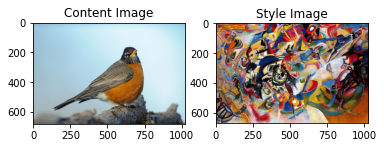

In [19]:
content_img_original = load_img('bird.jpg', opts)
style_img_original = load_img('Vassily_Kandinsky_1913_Composition_7.jpg', opts)

plt.subplot(1, 2, 1)
display_img(content_img_original, title='Content Image')

plt.subplot(1, 2, 2)
display_img(style_img_original, title='Style Image')

content_img = tf.Variable(content_img_original)
style_img = tf.Variable(style_img_original)

## 2.7 Append Activation Targets to Training Opts

In [20]:
preprocess_content_img = preprocess_step_input(content_img)
preprocess_style_img = preprocess_step_input(style_img)

content_activation_target = extractor(preprocess_content_img)[:num_layers_content]
style_activation_target = extractor(preprocess_style_img)[num_layers_content:]

content_activation_dict = {
    name: value
    for name, value
    in zip(content_layers, content_activation_target)
}

style_activation_dict = {
    name: value
    for name, value
    in zip(style_layers, style_activation_target)
}

opts['content_activation_target'] = content_activation_dict
opts['style_activation_target'] = style_activation_dict

## 2.7 Run a few training loops and verify results

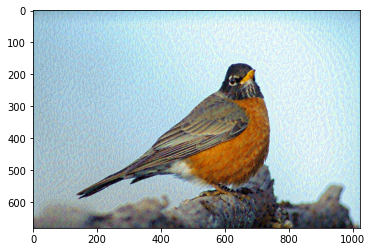

In [21]:
style_transfer_step(content_img, extractor, calc_loss, optimizer, opts)
style_transfer_step(content_img, extractor, calc_loss, optimizer, opts)
style_transfer_step(content_img, extractor, calc_loss, optimizer, opts)

display_output = deprocess_output(content_img)
display_img(display_output)

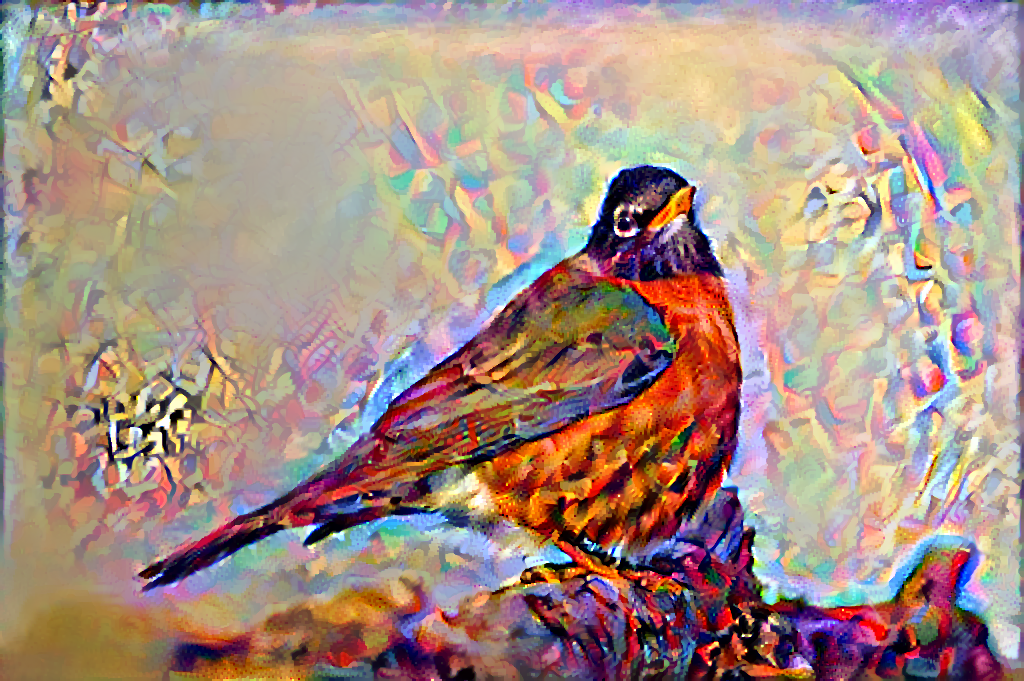

In [22]:
style_transfer_loop(content_img, extractor, calc_loss, optimizer, opts)

In [23]:
final_img = deprocess_output(content_img)
save_img(final_img, 'bird_style_tranfer.jpg')